# import

In [27]:
import os
from tqdm import tqdm
from IPython.display import clear_output

import numpy as np
from numpy import dot
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# read df_tidy

In [23]:
dir_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
fig_dir = r'C:\Users\lan\Documents\repos\inter\results\decorrelation vs adp\ref=self before adp'.replace('\\', os.sep)
dir_file = os.path.join(dir_inter, 'adp_dataset_master.xlsx')
data_info = pd.read_excel(dir_file)
data_info.head()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'LM')
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # ensure segmentation
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta_LM = meta.copy()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'V1') 
                 & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # there are 2 data in V1 that haven't been segmented due to cellpose failing with low quality tiff
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta_V1 = meta.copy()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'LI') 
                 & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
                 & (data_info.manual_seg != 'TODO') # 2 LI data still need manual segm
                 & (data_info.note.str.contains('bad') != True) # exclude bad data
                 ]
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta_LI = meta.copy()

meta = pd.concat([meta_V1, meta_LM, meta_LI], axis=0).reset_index(drop=True)
# meta

LM    22
Name: area, dtype: int64 22
V1    6
Name: area, dtype: int64 6
LI    18
Name: area, dtype: int64 18


In [14]:
nset = len(meta)
df_tidy = pd.DataFrame()

for iset in tqdm(range(nset)):
    # print(f'iset={iset}, nset={nset}')

    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    # sess = '00' + meta.loc[iset, 'num'].astype(str)
    sess = meta.loc[iset, 'num']
    # print(imouse, date, area, sess)
    dir_identifier = f'{area}_{imouse}_{date}_{sess}'

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    csv_filename = 'df_tidy_continuous_vis_pval.csv'
    try:
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))
    except:
        dir_identifier = dir_identifier + '_cellpose'
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))

    df_tidy_now['mouse'] = mouse
    df_tidy_now['date'] = date
    df_tidy_now['sess'] = sess
    df_tidy_now['cell_id'] = (df_tidy_now.date.astype(str) + '_' 
                               + df_tidy_now.sess.astype(str) + '_' 
                               + df_tidy_now.cell_id.astype(str)) # cell_id adjusted to be unique across mice, dates, sessions
    df_tidy = pd.concat([df_tidy, df_tidy_now], axis=0).reset_index(drop=True)
    # break
    
clear_output()

# print(df_tidy.mouse.unique(), 
#       df_tidy.date.unique(), 
#       df_tidy.sess.unique(), 
#       df_tidy.area.unique(), 
#       df_tidy.isi.unique(), 
#       df_tidy.stim1_contrast.unique(), 
#       df_tidy.stim2_id.unique(), 
#       df_tidy.resp_id.unique())
# df_tidy.sample(5, random_state=0)

['1323' '1324' '1322' '1328' '1329' '1337' '1338' '1350' '1351' '1380'
 '1373' '1381' '1339'] ['200720' '200728' '200803' '201015' '201209' '210120' '200721' '200729'
 '200804' '201119' '201127' '201217' '210127' '210325' '210805' '211020'
 '220228' '230221' '230302' '230307' '200723' '200806' '201202' '210113'
 '210203' '210930' '211028' '230110' '230228' '230309'] ['003' '002' '004' '006'] ['V1' 'LM' 'LI'] [ 750  250 6000] [1 0] [5 2 3 0 7 4 1 6] ['R1' 'R2']


,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,filter_cell_vis_pval,filter_cell_well_fit,filter_cell_stim,mouse,date,sess
1535086,0.240415,230302_004_131,195,R1,250,1,6,LM,0,True,3.519462e-09,0.0,False,1373,230302,004
1498362,0.018307,230302_004_25,274,R1,750,1,6,LM,0,True,1.549022e-02,1.0,False,1373,230302,004
10251,0.200723,200720_003_31,432,R1,250,1,7,V1,0,False,7.609371e-02,0.0,False,1323,200720,003
26153,-0.088930,200720_003_81,217,R1,250,1,3,V1,0,False,8.084665e-02,1.0,False,1323,200720,003
1794444,-0.057807,230307_004_76,294,R1,750,1,0,LM,0,False,1.724086e-01,0.0,False,1381,230307,004


# data prep

In [52]:
pd.options.mode.chained_assignment = None  # default='warn' # suppress SettingWithCopyWarning

df_decorr = df_tidy[['dfof', 
                    'cell_id', 'resp_id', 'isi', 'stim2_id', 
                    'filter_cell_vis', 'filter_cell_stim', 'filter_cell_well_fit', 
                    'area', 'mouse', 'date', 'sess'
                    ]]

df_decorr['stim2_dist'] = df_decorr.stim2_id.apply(lambda x: 22.5*(8-x) if x > 4 else 22.5*x) 
                          # stim2 distance from 0 deg, hard coded for 8 ori. TODO: modify if needed
df_decorr['date_sess'] = df_decorr.date + '_' + df_decorr.sess

current_area = 'LI'
df_decorr = df_decorr[(df_decorr.isi != 750)
                      & (df_decorr.filter_cell_vis == True)
                      # & (df_decorr.filter_cell_stim == True)
                      & (df_decorr.filter_cell_well_fit == True)
                      & (df_decorr.resp_id == 'R2')
                      & (df_decorr.area == current_area)
                    ]
df_decorr

,dfof,cell_id,resp_id,isi,stim2_id,filter_cell_vis,filter_cell_stim,filter_cell_well_fit,area,mouse,date,sess,stim2_dist,date_sess
1865675,0.050601,200723_003_5,R2,250,5,True,False,1.0,LI,1323,200723,003,67.5,200723_003
1865676,0.045490,200723_003_5,R2,250,4,True,False,1.0,LI,1323,200723,003,90.0,200723_003
1865678,-0.002333,200723_003_5,R2,250,6,True,False,1.0,LI,1323,200723,003,45.0,200723_003
1865679,-0.007552,200723_003_5,R2,6000,6,True,False,1.0,LI,1323,200723,003,45.0,200723_003
1865680,0.153027,200723_003_5,R2,250,4,True,False,1.0,LI,1323,200723,003,90.0,200723_003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288128,0.014526,230228_003_47,R2,250,6,True,False,1.0,LI,1373,230228,003,45.0,230228_003
2288130,0.016671,230228_003_47,R2,6000,1,True,False,1.0,LI,1373,230228,003,22.5,230228_003
2288132,-0.015730,230228_003_47,R2,250,0,True,False,1.0,LI,1373,230228,003,0.0,230228_003
2288133,-1.163766,230228_003_47,R2,6000,0,True,False,1.0,LI,1373,230228,003,0.0,230228_003


## decorr from self
before vs after adp

In [53]:
cos_sim_sets = []
for iset in tqdm(df_decorr.date_sess.unique()):
    
    df_pop_vec = (df_decorr[df_decorr.date_sess == iset]
                  .groupby(['isi', 'stim2_dist', 'cell_id'])
                  .dfof.mean().reset_index()
                  .pivot_table(index=['isi', 'stim2_dist'], 
                               columns='cell_id', 
                               values='dfof') # for each isi and stim2_dist, get a pop vector of size [ncell, 1]
                )
    nori = df_decorr.stim2_dist.nunique()
    
    cos_sim_iset = []
    for iori in range(nori):
        pop_vec_ref = df_pop_vec.iloc[nori + iori, :].values # ref is the same ori, but before adp (isi=6000)
        pop_vec_ori = df_pop_vec.iloc[iori, :].values # pop vec after adp (isi=250)
        cos_sim = dot(pop_vec_ref, pop_vec_ori) / (norm(pop_vec_ref) * norm(pop_vec_ori)) # cosine similarity
        cos_sim_iset.append(cos_sim)
    cos_sim_sets.append(cos_sim_iset)
    
len(cos_sim_sets), len(cos_sim_sets[0]) # n of recording, n of self-decorrelation pairs (nori)

100%|██████████| 6/6 [00:00<00:00, 61.17it/s]


(6, 5)

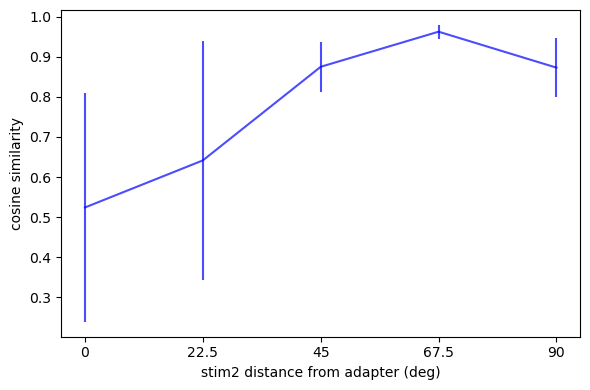

In [54]:
cos_sim_sets = np.array(cos_sim_sets)
cos_sim_sets_avg = np.nanmean(cos_sim_sets, axis=0) # across recordings
cos_sim_sets_sem = np.nanstd(cos_sim_sets, axis=0) / np.sqrt(cos_sim_sets.shape[0])

fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharex=True)
ax.errorbar(x=np.arange(len(cos_sim_sets_avg)),
               y=cos_sim_sets_avg,
               yerr=cos_sim_sets_sem,
               color='blue', # label='isi 250', 
               alpha=0.7)

# ax.legend(frameon=False, loc='lower center')
ax.set_xlabel('stim2 distance from adapter (deg)');
ax.set_ylabel('cosine similarity')
ax.set_xticks(range(nori), ['0', '22.5', '45', '67.5', '90'])

fig.tight_layout();
fig_name = 'decorr_from_self_after_adp_well_fit_' + current_area + '.pdf'
# plt.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

## decorr from ref ori

In [57]:
(df_tidy[(df_tidy.filter_cell_vis == True)
        #  & (df_tidy.filter_cell_well_fit == True)
         ]
        .groupby('area')
        .cell_id.nunique())

area
LI    222
LM    983
V1    449
Name: cell_id, dtype: int64

In [ ]:
''' 
if resample cells without affecting trials: 
1. groupby cell_id, then sample n cells. set cell_id as index, use df.reindex(cell_id) to get the resampled df
2. set cell_id as index in df_decorr, df_decorr[df_decorr.cell_id.isin(subsample_cell)] -> df.reindex
3. df_pop_vec. ... .groupby, reset_index, sample n cells, pivot_table
'''

In [ ]:
## bootstrap resample cells to get error bar

nboot = 100
# subsample_cell_ratio = 0.7
# ncell_subsample = (df_tidy[(df_tidy.filter_cell_vis == True)]
#                    .groupby('area')
#                    .cell_id.nunique()
#                    .min()) # min ncells across areas - determine subsample size
cos_sim_boots = []

for iboot in tqdm(range(nboot)):
    
    np.random.seed(iboot)
    subsample_cell = np.random.choice(df_decorr.cell_id.unique(), 
                                    #   size=int(subsample_cell_ratio*df_decorr.cell_id.nunique()), 
                                    #   size=ncell_subsample,
                                      size=df_decorr.cell_id.nunique(), 
                                      replace=True)
    
    # df_pop_vec = df_decorr.sample(frac=1, 
    #                               replace=True, 
    #                               random_state=iboot) # resample cellxtrial (row-wise) with replacement, same size as original
    
    df_pop_vec = (df_decorr # [df_decorr.cell_id.isin(subsample_cell)]
                  .groupby(['isi', 'stim2_dist', 'cell_id'])
                  .dfof.median().reset_index() # cell-level median, under each isi-stim2_dist condition
                  .groupby(['isi', 'stim2_dist'])
                  .sample(frac=3, replace=True, random_state=iboot) # resample cells with replacement in each cond
                  .pivot_table(index=['isi', 'stim2_dist'], columns='cell_id', values='dfof') # df allows duplicate columns
                  .fillna(0) # fill nan with 0, bc some cells are not sampled in some conditions
                )
    nori = df_decorr.stim2_dist.nunique()
    nisi_now = df_decorr.isi.nunique() # discarded isi 750

    cos_sim_iboot = []
    for iisi in range(nisi_now):
        if iisi == 0:
            # iref = 0
            iref = 4
        elif iisi == 1:
            # iref = nori
            iref = nori+4 # -1 (0-based indexing) and +1 (go to next isi) cancel out
        pop_vec_ref = df_pop_vec.iloc[iref, :].values # reference pop vec: 0 deg target resp
        
        for iori in range(nori):
            irow = iisi * nori + iori
            pop_vec_ori = df_pop_vec.iloc[irow, :].values
            cos_sim = dot(pop_vec_ref, pop_vec_ori) / (norm(pop_vec_ref) * norm(pop_vec_ori))
            cos_sim_iboot.append(cos_sim)
    cos_sim_boots.append(cos_sim_iboot)
    
len(cos_sim_boots), len(cos_sim_boots[0]) # n of boot, n of decorrelation pairs (nisi * nori)

100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


(100, 10)

In [ ]:
# tmp = (df_decorr # [df_decorr.cell_id.isin(subsample_cell)]
#         .groupby(['isi', 'stim2_dist', 'cell_id'])
#         .dfof.median().reset_index() # cell-level median, under each isi-stim2_dist condition
#         .groupby(['isi', 'stim2_dist'])
#         .sample(frac=4/122, replace=True, random_state=0) # resample cells with replacement, same size as original
#         .groupby(['isi', 'stim2_dist'])
#         # .pivot_table(index=['isi', 'stim2_dist'], columns='cell_id', values='dfof')
#         )
# tmp#.cell_id.nunique(), df_decorr.cell_id.nunique()

# for key, group in tmp:
#     # print(key)
#     # print(group)
#     break
# group.cell_id.nunique(), df_decorr.cell_id.nunique()
# group

,isi,stim2_dist,cell_id,dfof
44,250,0.0,210203_003_21,0.025144
47,250,0.0,210203_003_30,0.015220
117,250,0.0,230228_003_4,-0.011095
64,250,0.0,230110_002_32,0.025775


In [ ]:
## separate recordings to get error bar

# cos_sim_sets = []
# for iset in tqdm(df_decorr.date_sess.unique()):
#     # print(iset)
    
#     df_pop_vec = (df_decorr[df_decorr.date_sess == iset]
#                   .groupby(['isi', 'stim2_dist', 'cell_id'])
#                   .dfof.mean().reset_index()
#                   .pivot_table(index=['isi', 'stim2_dist'], columns='cell_id', values='dfof')
#                 )
#     nori = df_decorr.stim2_dist.nunique()
#     nisi_now = df_decorr.isi.nunique() # discarded isi 750

#     cos_sim_iset = []
#     for iisi in range(nisi_now):
#         if iisi == 0:
#             iref = 0
#             # iref = 4
#         elif iisi == 1:
#             iref = nori
#             # iref = nori+4 # -1 (0-based indexing) and +1 (go to next isi) cancel out
#         pop_vec_ref = df_pop_vec.iloc[iref, :].values # reference pop vec: 0 deg target resp
        
#         for iori in range(nori):
#             irow = iisi * nori + iori
#             pop_vec_ori = df_pop_vec.iloc[irow, :].values
#             cos_sim = dot(pop_vec_ref, pop_vec_ori) / (norm(pop_vec_ref) * norm(pop_vec_ori))
#             cos_sim_iset.append(cos_sim)
#     cos_sim_sets.append(cos_sim_iset)
    
# len(cos_sim_sets), len(cos_sim_sets[0]) # n of recording, n of decorrelation pairs (nisi * nori)

100%|██████████| 18/18 [00:00<00:00, 33.49it/s]


(18, 10)

In [ ]:
# ## save boot
# # V1_decorr_boot = cos_sim_boots.copy()
# # LM_decorr_boot = cos_sim_boots.copy()
# # LI_decorr_boot = cos_sim_boots.copy()

# # decorr_boot = {'V1_decorr_boot': V1_decorr_boot,
# #                'LM_decorr_boot': LM_decorr_boot,
# #                'LI_decorr_boot': LI_decorr_boot,}

# # import pickle
# # pickle_dir = r'C:\Users\lan\Documents\repos\inter\results\decorrelation vs adp\ref=90 deg'.replace('\\', os.sep)
# # pickle_name = 'decorr_vs_stim2_dist_errorbar_bootstrap_CI_' + '.pickle'
# # with open(os.path.join(pickle_dir, pickle_name), 'wb') as handle:
# #     pickle.dump(decorr_boot, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# ## load boot
# with open(os.path.join(pickle_dir, pickle_name), 'rb') as handle:
#     decorr_boot = pickle.load(handle)
# decorr_boot.keys()

# V1_decorr_boot = decorr_boot['V1_decorr_boot']
# LM_decorr_boot = decorr_boot['LM_decorr_boot']
# LI_decorr_boot = decorr_boot['LI_decorr_boot']

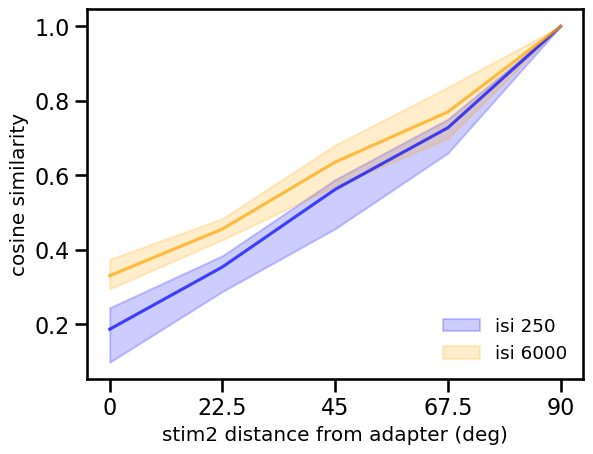

In [ ]:
cos_sim_sets = np.array(cos_sim_boots)
cos_sim_sets_avg = np.mean(cos_sim_sets, axis=0) # across boots

perc = 2.5
plt.plot(cos_sim_sets_avg[:nori], color='blue', alpha=0.7)
plt.fill_between(x=np.arange(nori),
                y1=np.percentile(cos_sim_sets, perc, axis=0)[:nori],
                y2=np.percentile(cos_sim_sets, 100-perc, axis=0)[:nori],
                label='isi 250',
                color='blue', alpha=0.2)

plt.plot(cos_sim_sets_avg[nori:], color='orange', alpha=0.7)
plt.fill_between(x=np.arange(nori),
                y1=np.percentile(cos_sim_sets, perc, axis=0)[nori:],
                y2=np.percentile(cos_sim_sets, 100-perc, axis=0)[nori:],
                label='isi 6000',
                color='orange', alpha=0.2);
plt.legend(frameon=False, loc='lower right')

# ## annotate significance
# for iori in np.arange(nori)[:-1]: # exclude 90 deg
#     plt.annotate(sig_star_list[iori], xy=(iori, 1), fontsize=12, ha='center', va='center')

# plt.ylim(0.2, 1.05)
plt.xlabel('stim2 distance from adapter (deg)');
plt.ylabel('cosine similarity')
plt.xticks(range(nori), ['0', '22.5', '45', '67.5', '90'])

fig.tight_layout();
fig_dir = r'C:\Users\lan\Documents\repos\inter\results\decorrelation vs adp\ref=90 deg'.replace('\\', os.sep)
fig_name = f'decorr_fixed_resample_boot_CI{int(100-2*perc)}_median_' + current_area + '.pdf'
plt.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

### decorr vs stim2_ori

In [ ]:
df_pop_vec = (df_decorr.groupby(['isi', 'stim2_id', 'cell_id'])
                .dfof.mean().reset_index()
                .pivot_table(index=['isi', 'stim2_id'], columns='cell_id', values='dfof')
                )
df_pop_vec

cell_id        200723_003_1  200723_003_10  200723_003_11  200723_003_12  \
isi  stim2_id                                                              
250  0            -0.005401       0.007648       0.038531       0.011697   
     1            -0.020624      -0.019151      -0.015456      -0.015368   
     2            -0.007372       0.019836       0.098756       0.040590   
     3             0.063277       0.025829       0.040016      -0.029502   
     4             0.119146       0.001094       0.017127       0.011128   
     5             0.048175       0.032663       0.008627       0.040453   
     6             0.049623       0.059203       0.016605       0.015589   
     7            -0.025040       0.014491      -0.030827       0.034537   
6000 0            -0.004944       0.091272      -0.022213       0.043560   
     1             0.070847       0.062880       0.027504      -0.007658   
     2             0.078720       0.028448       0.171627       0.034132   
     3             0.080553       0.052082       0.114251       0.050209   
     4             0.064168       0.045880       0.047818       0.020374   
     5             0.105954       0.025416       0.005282       0.042583   
     6             0.082480       0.058769       0.002543       0.039387   
     7             0.051929       0.091695       0.000104       0.024366   

cell_id        200723_003_14  200723_003_15  200723_003_16  200723_003_18  \
isi  stim2_id                                                               
250  0             -0.008486       0.046037       0.025867      -0.040432   
     1              0.042805       0.011193       0.007441       0.044029   
     2              0.053564       0.174982       0.046541       0.026134   
     3              0.012289       0.112753       0.122199       0.078819   
     4              0.044916       0.150953      -0.004497       0.060277   
     5              0.057908       0.143648       0.013280       0.033569   
     6             -0.021378       0.127970      -0.060111       0.031628   
     7              0.005427       0.000863      -0.029145      -0.042133   
6000 0              0.068940       0.099363      -0.013935       0.028703   
     1              0.081273       0.135151       0.035943       0.073747   
     2              0.004838       0.104008       0.084809       0.076492   
     3              0.041151       0.123181       0.115130       0.076236   
     4              0.058745       0.143208       0.130853       0.042643   
     5              0.018433       0.117422       0.013840       0.074791   
     6              0.049893       0.185119       0.006089       0.067050   
     7              0.039748       0.074478      -0.026587       0.066704   

cell_id        200723_003_19  200723_003_2  ...  230309_002_55  230309_002_61  \
isi  stim2_id                               ...                                 
250  0              0.004073      0.031216  ...      -0.001467       0.012224   
     1             -0.029450      0.026072  ...      -0.016538       0.034560   
     2              0.004872      0.020765  ...      -0.005001       0.011898   
     3              0.095105      0.079738  ...      -0.001857      -0.006986   
     4              0.081349      0.046425  ...      -0.004717       0.004506   
     5              0.023795      0.051474  ...       0.004787      -0.008856   
     6             -0.009139      0.031187  ...      -0.022175       0.036889   
     7             -0.018550      0.040290  ...      -0.007384       0.019071   
6000 0              0.014449      0.108429  ...      -0.006541       0.004988   
     1              0.056210      0.070822  ...       0.003872       0.016538   
     2              0.053972      0.025485  ...       0.014926       0.025469   
     3              0.151666      0.100909  ...       0.001893       0.060940   
     4              0.100264      0.014833  ...      -0.010514       0.012296   
     5              0.108767 

In [ ]:
nori = df_decorr.stim2_id.nunique()
nisi_now = df_decorr.isi.nunique() # discarded isi 750

cos_sim_list = []
for iisi in range(nisi_now):
    
    if iisi == 0:
        iref = 4 # use 90 deg as ref
    elif iisi == 1:
        iref = nori+4 # -1 (0-based indexing) and +1 (go to next isi) cancel out
    pop_vec_ref = df_pop_vec.iloc[iref, :].values # reference pop vec: 0 deg target resp
    
    for iori in range(nori):
        irow = iisi * nori + iori
        # print(iisi, iori, irow)
        pop_vec_ori = df_pop_vec.iloc[irow, :].values
        cos_sim = dot(pop_vec_ref, pop_vec_ori) / (norm(pop_vec_ref) * norm(pop_vec_ori))
        cos_sim_list.append(cos_sim)

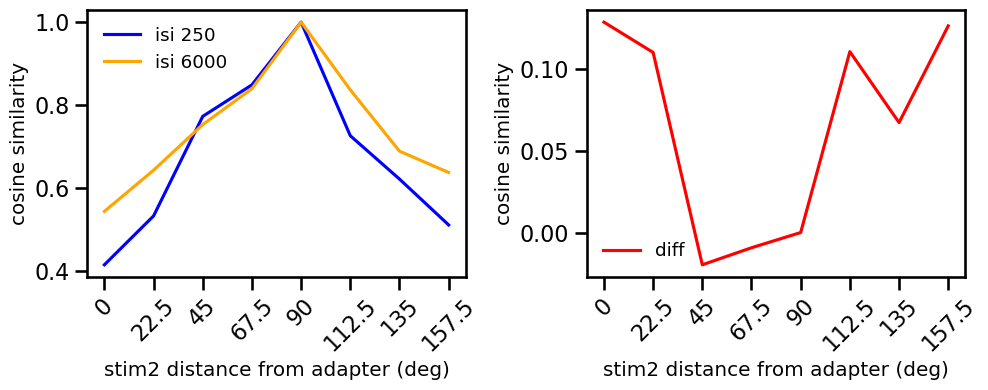

In [ ]:
cos_sim_list = np.array(cos_sim_list)

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
ax[0].plot(cos_sim_list[:nori], color='blue', label='isi 250')
ax[0].plot(cos_sim_list[nori:2*nori], color='orange', label='isi 6000')
ax[0].legend(frameon=False)

ax[1].plot(cos_sim_list[nori:2*nori] - cos_sim_list[:nori], color='red', label='diff')
ax[1].legend(frameon=False)

ax[0].set_xlabel('stim2 distance from adapter (deg)');
ax[0].set_ylabel('cosine similarity')
ax[0].set_xticks(range(nori), ['0', '22.5', '45', '67.5', '90', '112.5', '135', '157.5'], rotation=45)

ax[1].set_xlabel('stim2 distance from adapter (deg)');
ax[1].set_ylabel('cosine similarity')
ax[1].set_xticks(range(nori), ['0', '22.5', '45', '67.5', '90', '112.5', '135', '157.5'], rotation=45)

plt.tight_layout()
fig_dir = r'C:\Users\lan\Documents\repos\inter\results\decorrelation vs adp\ref=90 deg'.replace('\\', os.sep)
fig_name = 'decorr_vs_stim2_ori_' + current_area + '.pdf'
plt.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

### decorr vs stim2_dist
distance from adapter (0 deg)

In [ ]:
df_pop_vec = (df_decorr.groupby(['isi', 'stim2_dist', 'cell_id'])
                .dfof.mean().reset_index()
                .pivot_table(index=['isi', 'stim2_dist'], columns='cell_id', values='dfof')
                )
df_pop_vec

cell_id          200723_003_1  200723_003_10  200723_003_11  200723_003_12  \
isi  stim2_dist                                                              
250  0.0            -0.005401       0.007648       0.038531       0.011697   
     22.5           -0.023024      -0.000867      -0.023810       0.011754   
     45.0            0.024292       0.041707       0.053117       0.026700   
     67.5            0.056694       0.028808       0.026334       0.000991   
     90.0            0.119146       0.001094       0.017127       0.011128   
6000 0.0            -0.004944       0.091272      -0.022213       0.043560   
     22.5            0.061388       0.077287       0.013804       0.008354   
     45.0            0.080654       0.044041       0.084670       0.036834   
     67.5            0.092890       0.039130       0.061323       0.046505   
     90.0            0.064168       0.045880       0.047818       0.020374   

cell_id          200723_003_14  200723_003_15  200723_003_16  200723_003_18  \
isi  stim2_dist                                                               
250  0.0             -0.008486       0.046037       0.025867      -0.040432   
     22.5             0.022491       0.005579      -0.012443      -0.002798   
     45.0             0.011929       0.148864      -0.012710       0.029186   
     67.5             0.032174       0.126220       0.074722       0.059094   
     90.0             0.044916       0.150953      -0.004497       0.060277   
6000 0.0              0.068940       0.099363      -0.013935       0.028703   
     22.5             0.060510       0.104815       0.004678       0.070226   
     45.0             0.028009       0.145722       0.044324       0.071636   
     67.5             0.030116       0.120384       0.065932       0.075534   
     90.0             0.058745       0.143208       0.130853       0.042643   

cell_id          200723_003_19  200723_003_2  ...  230309_002_55  \
isi  stim2_dist                               ...                  
250  0.0              0.004073      0.031216  ...      -0.001467   
     22.5            -0.023526      0.033799  ...      -0.011129   
     45.0            -0.002912      0.026555  ...      -0.013328   
     67.5             0.064021      0.067418  ...       0.001677   
     90.0             0.081349      0.046425  ...      -0.004717   
6000 0.0              0.014449      0.108429  ...      -0.006541   
     22.5             0.037758      0.065268  ...      -0.000398   
     45.0             0.055914      0.019857  ...       0.007564   
     67.5             0.130829      0.072907  ...       0.012154   
     90.0             0.100264      0.014833  ...      -0.010514   

cell_id          230309_002_61  230309_002_79  230309_002_84  230309_002_86  \
isi  stim2_dist                                                               
250  0.0              0.012224      -0.008993       0.008518       0.017217   
     22.5             0.025407       0.001705      -0.005959       0.013086   
     45.0             0.024015       0.093804       0.003821       0.005552   
     67.5            -0.007980       0.049488      -0.000241       0.007012   
     90.0             0.004506       0.033759      -0.000547       0.036242   
6000 0.0              0.004988       0.027172       0.037115      -0.017311   
     22.5             0.011596       0.062406      -0.013651       0.007834   
     45.0             0.022510       0.079908       0.008351       0.022070   
     67.5             0.039286       0.046751       0.021350       0.012354   
     90.0             0.012296       0.068001       0.011025       0.037309   

cell_id          230309_002_89  230309_002_90  230309_003_17  230309_003_29  \
isi  stim2_dist                                                               
250  0.0              0.000927       0.000554       0.033249       0.067000   
     22.5             0.008694       0.003971      -0.003427       0.008000   
     45.0             0.023189  

In [ ]:
nori = df_decorr.stim2_dist.nunique()
nisi_now = df_decorr.isi.nunique() # discarded isi 750

cos_sim_list = []
for iisi in range(nisi_now):
    
    if iisi == 0:
        iref = 4
    elif iisi == 1:
        iref = nori+4 # -1 (0-based indexing) and +1 (go to next isi) cancel out
    pop_vec_ref = df_pop_vec.iloc[iref, :].values # reference pop vec: 0 deg target resp
    
    for iori in range(nori):
        irow = iisi * nori + iori
        # print(iisi, iori, irow)
        pop_vec_ori = df_pop_vec.iloc[irow, :].values
        cos_sim = dot(pop_vec_ref, pop_vec_ori) / (norm(pop_vec_ref) * norm(pop_vec_ori))
        cos_sim_list.append(cos_sim)

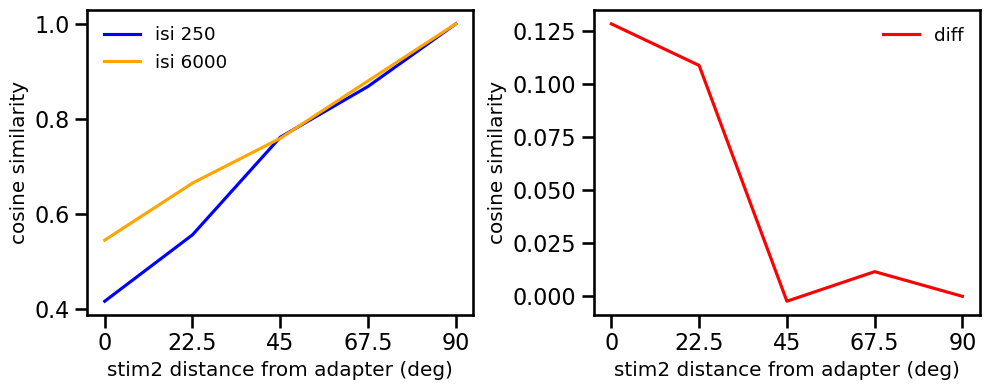

In [ ]:
cos_sim_list = np.array(cos_sim_list)

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
ax[0].plot(cos_sim_list[:nori], color='blue', label='isi 250')
ax[0].plot(cos_sim_list[nori:2*nori], color='orange', label='isi 6000')
ax[0].legend(frameon=False)

ax[1].plot(cos_sim_list[nori:2*nori] - cos_sim_list[:nori], color='red', label='diff')
ax[1].legend(frameon=False)

ax[0].set_xlabel('stim2 distance from adapter (deg)');
ax[0].set_ylabel('cosine similarity')
ax[0].set_xticks(range(nori), ['0', '22.5', '45', '67.5', '90'])

ax[1].set_xlabel('stim2 distance from adapter (deg)');
ax[1].set_ylabel('cosine similarity')
ax[1].set_xticks(range(nori), ['0', '22.5', '45', '67.5', '90'])

plt.tight_layout()
fig_dir = r'C:\Users\lan\Documents\repos\inter\results\decorrelation vs adp\ref=90 deg'.replace('\\', os.sep)
fig_name = 'decorr_vs_stim2_dist_' + current_area + '.pdf'
# plt.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')